# Dask start

In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:53936")
client

<Client: 'tcp://127.0.0.1:53936' processes=4 threads=8, memory=16.00 GiB>

# Import

In [25]:
#import s3fs
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.gridspec import GridSpec
import gsw
import gcm_filters
from xhistogram.xarray import histogram
import eos_module
from dask import compute
from dask.diagnostics import ProgressBar
from dask import delayed
import pandas as pd
import cartopy.crs as ccrs
from scipy.stats import kurtosis, skew, describe
from scipy import ndimage
from numpy.polynomial import polynomial as P
import xrft
import xrft_module
import inspect
import importlib

# Plotting params

In [3]:
#%matplotlib widget
%matplotlib inline

In [4]:
line_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#1f77b4']

In [5]:
cmaps_list = ['Blues', 'Oranges', 'Greens', 'Reds']

# Load data

Choose cases

In [6]:
data=[dict() for i in range(3)]

In [7]:
data[0] = dict({'region' : '1', 'season' : 'fma', 'label' : 'GULFSTR wint'})
data[1] = dict({'region' : '2', 'season' : 'aso', 'label' : 'ACORES sum'})
data[2] = dict({'region' : '3', 'season' : 'aso', 'label' : 'MEDWEST sum'})

In [8]:
x_slice = slice(0,-1)
y_slice = slice(0,-1)

data_slice = dict(time_counter=slice(0,-1,12),y=y_slice,x=x_slice)  # take every 50-th hourly output
coord_slice = dict(y=y_slice,x=x_slice)
nb_of_time_chunks = 6

## eNATL60

In [9]:
%%time
for i in range(len(data)) :
    #current_set = cat.eNATL60(region=data[i]['region'],datatype='surface_hourly', season=data[i]['season']).to_dask().\
    current_set = xr.open_mfdataset('/Users/ana/data/eNATL60_extractions/region'+data[i]['region']+'_'+data[i]['season']+'.nc', parallel=True).chunk({'time_counter' : nb_of_time_chunks, 'x' : -1, 'y' : -1}).\
    drop(['fmask','qt_oce', 'somecrty','sometauy','sossheig','sowaflup','sozocrtx','sozotaux','umask','vmask'],errors='ignore')
    current_set.coords['tmask'] = current_set.tmask.astype(np.float32)
    #current_set = current_set.resample({'time_counter' : resampling_avg_period}, closed='right', label='right').mean()
    current_set = current_set.isel(data_slice)
    current_set = current_set.chunk({'time_counter' : nb_of_time_chunks, 'x' : -1, 'y' : -1})
    current_set.load()
    current_set['x'] = np.arange(len(current_set['x']))
    current_set['y'] = np.arange(len(current_set['y']))
    data[i]['HR'] = current_set

CPU times: user 177 ms, sys: 127 ms, total: 304 ms
Wall time: 2.3 s


## eORCA025

In [10]:
for i in range(len(data)) :
    data[i]['LR'] = xr.open_mfdataset("/Users/ana/data/eNATL60_extractions/eORCA025/region"+data[i]['region']+"_"+data[i]['season']+".nc", \
                                          chunks={'time_counter' : nb_of_time_chunks, 'x' : -1, 'y' : -1}).\
    rename(nav_lat='lat', nav_lon='lon').isel(time_counter=slice(0,-1,10))

In [11]:
data[i]['LR'].sosstsst

<xarray.DataArray 'sosstsst' (time_counter: 6, y: 56, x: 41)>
dask.array<getitem, shape=(6, 56, 41), dtype=float32, chunksize=(1, 56, 41), chunktype=numpy.ndarray>
Coordinates:
    lat            (y, x) float32 dask.array<chunksize=(56, 41), meta=np.ndarray>
    lon            (y, x) float32 dask.array<chunksize=(56, 41), meta=np.ndarray>
    time_centered  (time_counter) datetime64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
  * time_counter   (time_counter) datetime64[ns] 2015-08-01T00:30:00 ... 2015...
    e1t            (y, x) float64 dask.array<chunksize=(56, 41), meta=np.ndarray>
    e2t            (y, x) float64 dask.array<chunksize=(56, 41), meta=np.ndarray>
  * x              (x) int64 0 1 2 3 4 5 6 7 8 9 ... 32 33 34 35 36 37 38 39 40
  * y              (y) int64 0 1 2 3 4 5 6 7 8 9 ... 47 48 49 50 51 52 53 54 55
    tmask          (y, x) float64 dask.array<chunksize=(56, 41), meta=np.ndarray>
Attributes:
    standard_name:       sea_surface_temperature
    long_name:           sea surface temperature
    units:               degC
    online_operation:    average
    interval_operation:  1200 s
    interval_write:      1 h
    cell_methods:        time: mean (interval: 1200 s)

## Plot

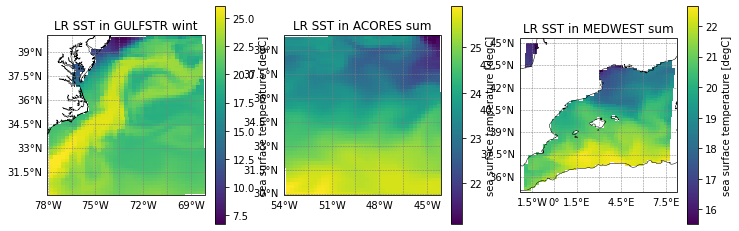

In [12]:
fig, axis = plt.subplots(ncols=len(data), nrows=1, figsize=(4*len(data),4), subplot_kw={'projection': ccrs.PlateCarree()}, squeeze=False)
for col in range(len(data)) :
    for row, dataSetKey in enumerate(['LR']) :
        data[col][dataSetKey].isel(time_counter=-1).sosstsst[coord_slice].plot(x='lon', y='lat', ax=axis[row,col])
        axis[row,col].set(title=dataSetKey + ' SST in ' + data[col]['label'])

for ax in axis.flatten() :
    ax.coastlines(color='k', lw=0.5)
    gl = ax.gridlines(draw_labels=True, x_inline=False, y_inline=False, color='grey', linestyle='dashed', linewidth=0.5)
    gl.top_labels = False; gl.right_labels = False

# Spectra

In [15]:
# without interpolation
def prepare_data_for_spec(data, variable) :
    res = data[variable].dropna(dim='y', thresh=3).dropna(dim='x', thresh=3)
    
    delta_x_min_m = res['e1t'].min().values
    delta_y_min_m = res['e2t'].min().values
    res.coords['x'] = res.coords['x']*delta_x_min_m
    res.coords['y'] = res.coords['y']*delta_y_min_m 

    # fill in nans
    # avg = step0.mean().compute()
    # data_filled_nans = interpolated_field.fillna(avg)
    res = res.interpolate_na(dim="x", method="linear", max_gap=15, limit=15)
    res = res.interpolate_na(dim="y", method="linear", max_gap=15, limit=15)
    res = res.interpolate_na(dim="x", method="nearest", fill_value="extrapolate")

    res = res.drop(['depth', 'e1f', 'e1u', 'e1v', 'e2f', 'e2u', 'e2v', 'lat', 'lon', 'nav_lat', 'nav_lon', 'e1t', 'e2t'], errors='ignore')
    return res

## Interpolation on a spatially uniform grid 

In [16]:
def uniform_grid_interpolation(data, variable) :
    # step0 : drop unecessary variables and coordinates out rows and cols consiting (almost) completely of nans
    step0 = data[variable].drop(['depth', 'e1f', 'e1u', 'e1v', 'e2f', 'e2u', 'e2v', 'lat', 'lon', 'nav_lat', 'nav_lon'], errors='ignore')
    step0 = step0.dropna(dim='y', thresh=3).dropna(dim='x', thresh=3)
    
    # switch to unit coordinates
    delta_x_min_m = step0['e1t'].min().values
    delta_y_min_m = step0['e2t'].min().values
    delta_min = np.min([delta_x_min_m, delta_y_min_m])
    new_x = np.cumsum(delta_min/step0['e1t'], axis=1)
    new_y = np.cumsum(delta_min/step0['e2t'], axis=0)

    # step 1 : fill in nans
    # avg = step0.mean().compute()
    # data_filled_nans = interpolated_field.fillna(avg)
    step1 = step0
    step1 = step1.interpolate_na(dim="x", method="linear", max_gap=15, limit=15)
    step1 = step1.interpolate_na(dim="y", method="linear", max_gap=15, limit=15)
    step1 = step1.interpolate_na(dim="x", method="nearest", fill_value="extrapolate")
    
    # step2 : interpotale onto a uniformly-spaced box
    step2 = step1.interp(x=new_x, y=new_y, method='linear')
    step2 = step2.dropna(dim='y', thresh=100).dropna(dim='x', thresh=100)

    if (step2.isnull().any().values == True) :
        step2 = step2.interpolate_na(dim="x", method="linear", fill_value="extrapolate")
        
    # step 3 : drop unecessey variables, add attribute, 
    step3 = step2.drop(['e1t', 'e2t'], errors='ignore')
    step3.attrs['delta_min'] = delta_min
    
    # return to unit coordinates (in meters) for correct computation of wavenumbers
    step3.coords['x'] = step3.coords['x']*delta_min
    step3.coords['y'] = step3.coords['y']*delta_min
    return step3

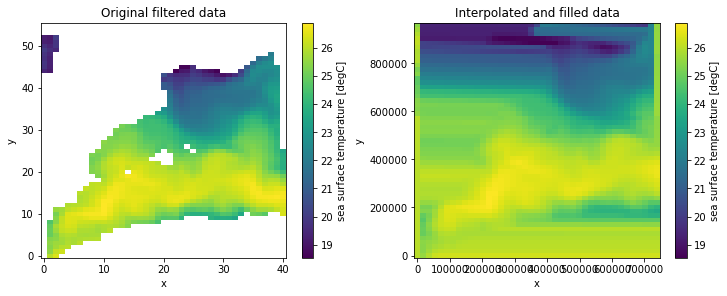

In [17]:
fig, ax = plt.subplots(ncols=2, constrained_layout=True, figsize=(10,4))
i_data = 2
(data[i_data]['LR'].isel(time_counter=0)).sosstsst.plot(ax=ax[0])
(uniform_grid_interpolation(data[i_data]['LR'], 'sosstsst').isel(time_counter=0)).plot(ax=ax[1])
ax[0].set(title='Original filtered data')
ax[1].set(title='Interpolated and filled data')
plt.show()

## Isotropic power spectra

In [18]:
#importlib.reload(xrft)

In [14]:
# source_DF = inspect.getsource(xrft.isotropize)
# print(source_DF)

In [19]:
def wrapper_xrtf_isotropic_PS(data, variable, binning_factor=4) :
    #prepared_data = uniform_grid_interpolation(data.drop(['tmask']), variable) # with interpolation on a uniform grid
    prepared_data = prepare_data_for_spec(data.drop(['tmask']), variable) # with interpolation on a uniform grid
    isotropic_power_spec = xrft.isotropic_power_spectrum(prepared_data, dim=['x','y'], detrend='linear', nfactor=binning_factor, truncate=True)
    return isotropic_power_spec.rename('Spatial_spectrum')

In [20]:
# initialize data structure for storing histograms
spec=[dict() for i in range(len(data))]
for i in range(len(data)) :
    spec[i]['LR'] = dict({'label' : 'eORCA025'})
    spec[i]['HR'] = dict({'label' : 'eNATL60'})

In [21]:
%%time 
for i in range(len(data)) :
    spec[i]['LR']['temp_spec'] = (wrapper_xrtf_isotropic_PS(data[i]['LR'], 'sosstsst')).mean(dim='time_counter').compute()
    spec[i]['HR']['temp_spec'] = (wrapper_xrtf_isotropic_PS(data[i]['HR'], 'sosstsst')).mean(dim='time_counter').compute()

CPU times: user 12.5 s, sys: 3.9 s, total: 16.4 s
Wall time: 13.6 s


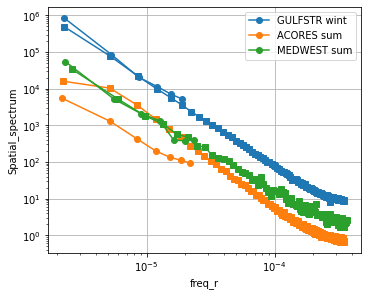

In [23]:
fig, ax = plt.subplots(ncols=1, constrained_layout=True, figsize=(5,4))
for data_i in range(len(data)) :
    spec[data_i]['LR']['temp_spec'].plot(x='freq_r', ax=ax, marker='o', color=line_colors[data_i], label=data[data_i]['label'])
    spec[data_i]['HR']['temp_spec'].plot(x='freq_r', ax=ax, marker='s', color=line_colors[data_i])
ax.set(xscale='log', yscale='log'); ax.grid(True)
ax.legend()
plt.show()

# Regridding